**Master Simulation**

Simulation of node states with pre processed distributions for group selection and uptime failures

In [61]:
import random
import simpy
import datetime
import numpy as np
import pandas as pd
import simulation_components as sc
import matplotlib.pyplot as plt

**Initialize Variables**

In [45]:
group_size = 100 # Group size
runs = 1000 # number of runs/cycles
total_tickets = 50000 # total virtual stakers
nodes = 100 # number of nodes
tickets = [] # initializing the array that will contain the tickets
group_members = [] # initializing the array that will contain indexes(node #) of tickets for each group
sim_cycles = 10 # maximum node cycles

**Simulation Inputs**

Text(0.5, 1.0, 'Virtual Staker Cumulative Distribution')

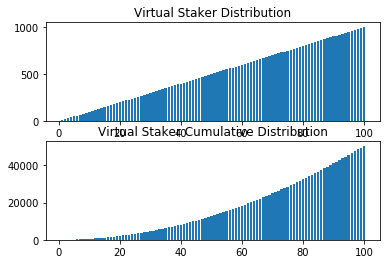

In [3]:
# Pre-processing Staker distributions
# Linear y = m * (x + 1) since indices start from 0
L02 = np.zeros(nodes) 

for i in range (0,nodes):
    L02[i] =  10 * (i + 1) # m = 50 gives max y as 1000 which is 2% of 50000

x = np.linspace(1,nodes,nodes)
plt.subplot(2, 1, 1)
plt.bar(x, L02)
plt.title("Virtual Staker Distribution")

cdf_L02=sc.create_cdf(nodes,L02)
plt.subplot(2, 1, 2)
plt.bar(x, cdf_L02)
plt.title("Virtual Staker Cumulative Distribution")

**Pre-processed tickets and groups**

In [6]:
tickets = sc.preprocess_tickets(runs, total_tickets)
group_members = sc.preprocess_groups(tickets, runs, group_size)

**Pre-processed node failure modes**

In [5]:
failed_nodes = sc.node_failure_modes(nodes, runs)

**Create Nodes and Start Simulation Environment**

In [62]:
env = simpy.Environment()
print("creating nodes")
node_array = [sc.Node(env, 'Node %d' % i, datetime.datetime.now(), 10)
            for i in range(10)] #number of nodes

df = []
for n in node_array:
    df.append([n.id, n.number_of_entries_generated
               , n.number_of_groups_joined
               , n.relay_request_time
               , n.relay_entry_watch_time])
    
df = pd.DataFrame(df)
df.columns=["id", "number_of_entries_generated", "number_of_groups_joined", "relay_request_time", "relay_entry_watch_time"]
df

creating nodes


,id,number_of_entries_generated,number_of_groups_joined,relay_request_time,relay_entry_watch_time
0,Node 0,0,0,0,0
1,Node 1,0,0,0,0
2,Node 2,0,0,0,0
3,Node 3,0,0,0,0
4,Node 4,0,0,0,0
5,Node 5,0,0,0,0
6,Node 6,0,0,0,0
7,Node 7,0,0,0,0
8,Node 8,0,0,0,0
9,Node 9,0,0,0,0


**Simulation Results**